In [40]:
import sys
sys.path.append('./utils')
from utils_imports import *


ModuleNotFoundError: No module named 'seaborn'

# train

In [ ]:
res = 5

In [4]:
points = get_points("dump.sqlite", until=pd.Timestamp("2024-01-30"))
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y

X = points[["lon", "lat"]].values
y = points["wait"].values
X.shape, y.shape

with open("models/kernel.pkl", "rb") as file:
    gpr = pickle.load(file)
    
print(gpr.regressor.optimizer)
gpr.regressor.optimizer = None
print(gpr.regressor.optimizer)

gpr = fit_gpr_silent(gpr, X, y)
raster_maker = raster_from_model(
    gpr,
    "world",
    res,
    show_uncertainties=True,
    verbose=True,
)

with open("jan.pkl", "wb") as file:
    pickle.dump(raster_maker, file)

fmin_l_bfgs_b
None
Compute rows of pixels...


  0%|          | 0/3600 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
points = get_points("dump.sqlite", until=pd.Timestamp("2024-03-30"))
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y

X = points[["lon", "lat"]].values
y = points["wait"].values
X.shape, y.shape

with open("models/kernel.pkl", "rb") as file:
    gpr = pickle.load(file)
    
print(gpr.regressor.optimizer)
gpr.regressor.optimizer = None
print(gpr.regressor.optimizer)

gpr = fit_gpr_silent(gpr, X, y)
raster_maker = raster_from_model(
    gpr,
    "world",
    res,
    show_uncertainties=True,
    verbose=True,
)

with open("mar.pkl", "wb") as file:
    pickle.dump(raster_maker, file)

In [ ]:
points = get_points("dump.sqlite", until=pd.Timestamp("2024-05-30"))
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y

X = points[["lon", "lat"]].values
y = points["wait"].values
X.shape, y.shape

with open("models/kernel.pkl", "rb") as file:
    gpr = pickle.load(file)
    
print(gpr.regressor.optimizer)
gpr.regressor.optimizer = None
print(gpr.regressor.optimizer)

gpr = fit_gpr_silent(gpr, X, y)
raster_maker = raster_from_model(
    gpr,
    "world",
    res,
    show_uncertainties=True,
    verbose=True,
)

with open("may.pkl", "wb") as file:
    pickle.dump(raster_maker, file)

In [ ]:
points = get_points("dump.sqlite", until=pd.Timestamp("2024-07-30"))
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y

X = points[["lon", "lat"]].values
y = points["wait"].values
X.shape, y.shape

with open("models/kernel.pkl", "rb") as file:
    gpr = pickle.load(file)
    
print(gpr.regressor.optimizer)
gpr.regressor.optimizer = None
print(gpr.regressor.optimizer)

gpr = fit_gpr_silent(gpr, X, y)
raster_maker = raster_from_model(
    gpr,
    "world",
    res,
    show_uncertainties=True,
    verbose=True,
)

with open("jul.pkl", "wb") as file:
    pickle.dump(raster_maker, file)

In [ ]:
points = get_points("dump.sqlite", until=pd.Timestamp("2024-09-30"))
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y

X = points[["lon", "lat"]].values
y = points["wait"].values
X.shape, y.shape

with open("models/kernel.pkl", "rb") as file:
    gpr = pickle.load(file)
    
print(gpr.regressor.optimizer)
gpr.regressor.optimizer = None
print(gpr.regressor.optimizer)

gpr = fit_gpr_silent(gpr, X, y)
raster_maker = raster_from_model(
    gpr,
    "world",
    res,
    show_uncertainties=True,
    verbose=True,
)

with open("sep.pkl", "wb") as file:
    pickle.dump(raster_maker, file)

In [ ]:
points = get_points("dump.sqlite", until=pd.Timestamp("2024-11-30"))
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y

X = points[["lon", "lat"]].values
y = points["wait"].values
X.shape, y.shape

with open("models/kernel.pkl", "rb") as file:
    gpr = pickle.load(file)
    
print(gpr.regressor.optimizer)
gpr.regressor.optimizer = None
print(gpr.regressor.optimizer)

gpr = fit_gpr_silent(gpr, X, y)
raster_maker = raster_from_model(
    gpr,
    "world",
    res,
    show_uncertainties=True,
    verbose=True,
)

with open("nov.pkl", "wb") as file:
    pickle.dump(raster_maker, file)

In [ ]:
stop

# draw

In [41]:
from datasets import load_dataset
import matplotlib.pyplot as plt

In [42]:
import xyzservices.providers as xyz
import folium
lon, lat = 12, 48.875
zoom_start = 2


tiles = xyz.CartoDB.Positron
m = folium.Map(
    tiles=folium.TileLayer(no_wrap=True, tiles=tiles),
    attr="Dummy",
    zoom_start=zoom_start,
    location=[lat, lon],
)

In [43]:
BUCKETS = [
    "#008200",  # dark green
    "#00c800",  # light green
    "#c8ff00",  # light yellow
    "#ffff00",  # yellow
    "#ffc800",  # light orange
    "#ff8200",  # dark orange
    "red",  # red
    "#c80000",  # dark red
    "#820000",  # wine red
    "#330100",  # drop?
]

# define the heatmap color scale
# values higher than the upper boundary are colored in the upmost color
BOUNDARIES = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

import matplotlib.colors as colors
cmap = colors.ListedColormap(BUCKETS)

norm = colors.BoundaryNorm(BOUNDARIES, cmap.N, clip=True)
cmap.set_bad(color="#000000", alpha=0.0) # opaque for NaN values (sea)

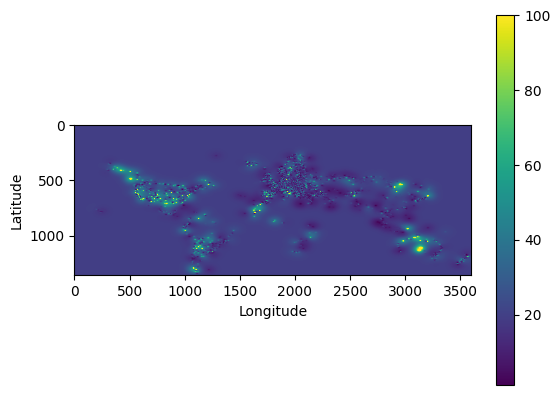

In [44]:
ds = load_dataset("tillwenke/heatchmap-map", cache_dir="intermediate/huggingface")
ds = ds.with_format("np")
image = ds["train"]["numpy"]
plt.imshow(image.clip(0,100), cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [52]:
cmap(2)

(np.float64(0.7843137254901961),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(1.0))

In [45]:
import numpy as np

# Input 2D scalar array
scalars = image
# opacities = uncertainties

# Apply the colormap to scalars
colors = cmap(scalars)
colors

array([[[0.2       , 0.00392157, 0.        , 1.        ],
        [0.2       , 0.00392157, 0.        , 1.        ],
        [0.2       , 0.00392157, 0.        , 1.        ],
        ...,
        [0.2       , 0.00392157, 0.        , 1.        ],
        [0.2       , 0.00392157, 0.        , 1.        ],
        [0.2       , 0.00392157, 0.        , 1.        ]],

       [[0.2       , 0.00392157, 0.        , 1.        ],
        [0.2       , 0.00392157, 0.        , 1.        ],
        [0.2       , 0.00392157, 0.        , 1.        ],
        ...,
        [0.2       , 0.00392157, 0.        , 1.        ],
        [0.2       , 0.00392157, 0.        , 1.        ],
        [0.2       , 0.00392157, 0.        , 1.        ]],

       [[0.2       , 0.00392157, 0.        , 1.        ],
        [0.2       , 0.00392157, 0.        , 1.        ],
        [0.2       , 0.00392157, 0.        , 1.        ],
        ...,
        [0.2       , 0.00392157, 0.        , 1.        ],
        [0.2       , 0.003921

In [46]:
# # Combine RGB values with the opacity
# rgba_array = np.empty_like(colors)
# rgba_array[:, :, :3] = colors[:, :, :3]  # RGB
# # rgba_array[:, :, 3] = opacities  # A
# rgba_array[:, :, 3] = 1.0
 
# # Verify shape and content
# print(rgba_array.shape)

(1360, 3600, 4)


In [48]:
folium.raster_layers.ImageOverlay(
    image=colors,
    bounds=[[-56, -180], [80, 180]],
).add_to(m)

/home/till/.local/lib/python3.10/site-packages/branca/utilities.py:329: RuntimeWarning: invalid value encountered in divide
  array = array * 255./array.max(axis=(0, 1)).reshape((1, 1, 4))
/home/till/.local/lib/python3.10/site-packages/branca/utilities.py:330: RuntimeWarning: invalid value encountered in cast
  array = array.astype('uint8')



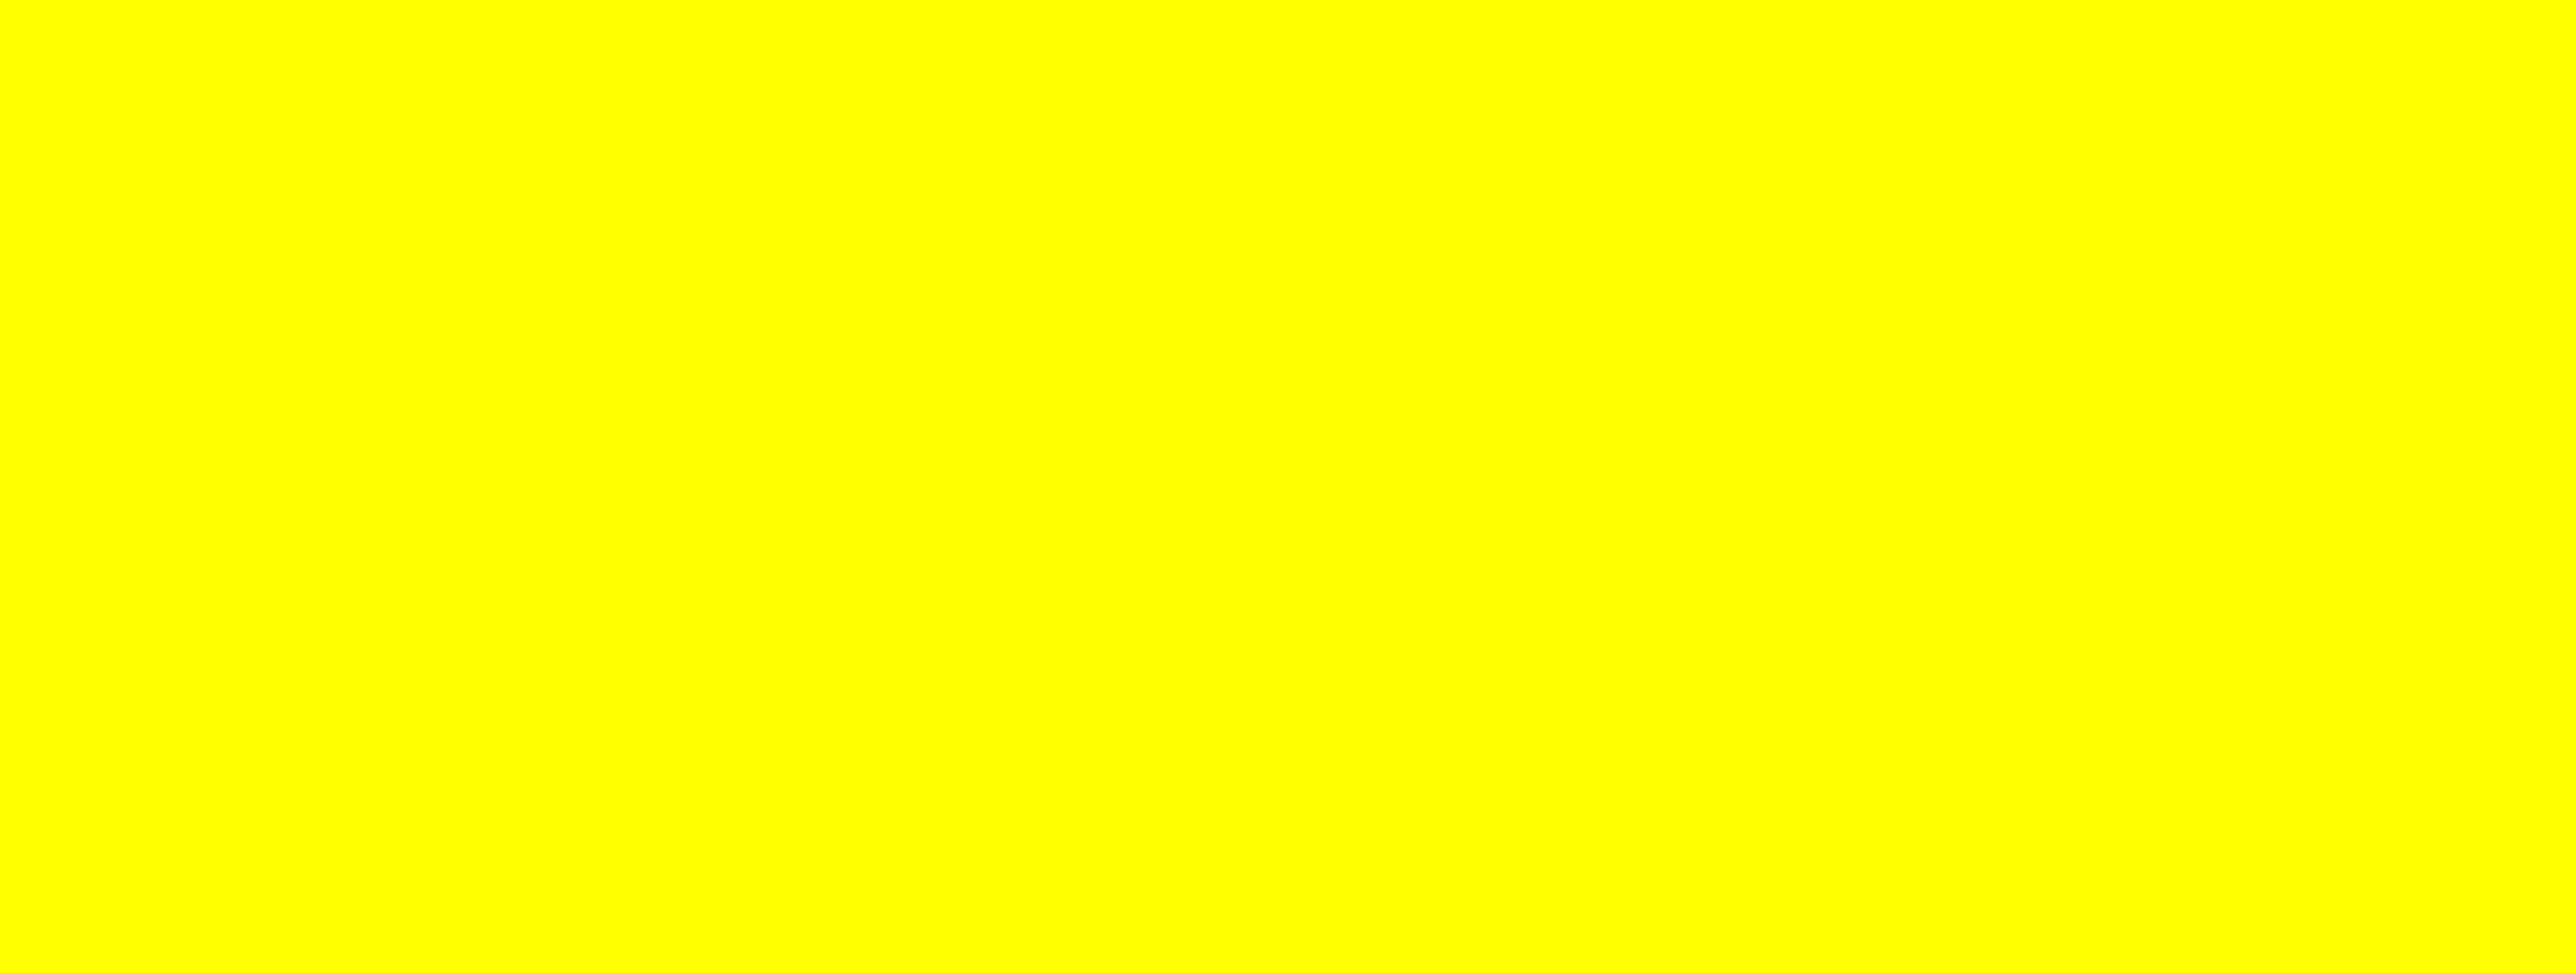

In [49]:
m